In [1]:
# this clones the PGM repository in the ./PGM folder if it does not exists
# please modify this line as needed if you want to have the PMG repository elsewhere
import os, sys
pgm_path = './PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append('./PGM/source/')
sys.path.append('./PGM/utilities/')
sys.path.append('./DNA_utils/')

In [ ]:
# imports 
from common_imports import set_num_threads
set_num_threads(2) # Set the number of cores. Must be executed before importing numpy&numba.
import rbm, RBM_utils
import DNA_utils, DNA_sequence_logo, DNA_plots_utils

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import string
%matplotlib inline

In [3]:
# load round 8 data
path = './data/'
filename = 's100_8th.fasta'
all_seq_8, counts_8 = DNA_utils.load_DNA_MSA(path + filename, drop_duplicates=True, with_counts = True)
n_tot_8 = all_seq_8.shape[0]
seq_len_8 = all_seq_8.shape[1]
print('Dataset #8 shape =', all_seq_8.shape)

Dataset #8 shape = (719413, 40)


In [4]:
# load pre-trained RBM 
path = './trained_RBMs/'
file_name = 'myrbm-noweights-8th-all_data.data'
RBM = RBM_utils.loadRBM(path+file_name)

In [5]:
# prepare weight norm data
norm_w_mins = []
for w in RBM.weights:
    norm_w = w / np.linalg.norm(w)
    norm_w_l = np.sum(norm_w[:20]**2)
    norm_w_r = np.sum(norm_w[20:]**2)
    norm_w_mins.append(min(norm_w_l, norm_w_r))
    
#select the top-norm weights on left and right
order = np.argsort(-RBM_utils.get_norm(RBM.weights))
sorted_weights = RBM.weights[order]

# create a vector with hu ordered by norms (in decreasing order)
beta = RBM_utils.get_norm(RBM.weights)
order = np.argsort(beta)[::-1]

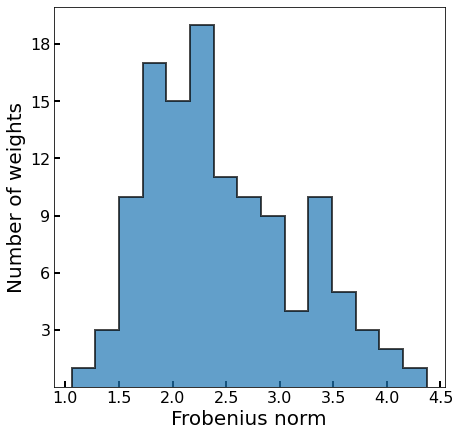

In [6]:
# histogram of weight norms
fig = plt.figure(figsize=(7, 7), constrained_layout=False)
gs = fig.add_gridspec(ncols=1, nrows=1, wspace=0.2)
##########################################################
ax1 = fig.add_subplot(gs[0,0])
ax1.hist(RBM_utils.get_norm(RBM.weights), bins=15, histtype='step',
         lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_xlabel('Frobenius norm', fontsize=20)
ax1.set_ylabel('Number of weights', fontsize=20)
ax1.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax1.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax1.tick_params(axis='both', labelsize=16)
ax1.set_yticks(np.array([3,6,9,12,15,18]));

In [7]:
# compute inputs
I_lr_c  = RBM.input_hiddens(all_seq_8)

Text(0.03, 0.88, 'f')

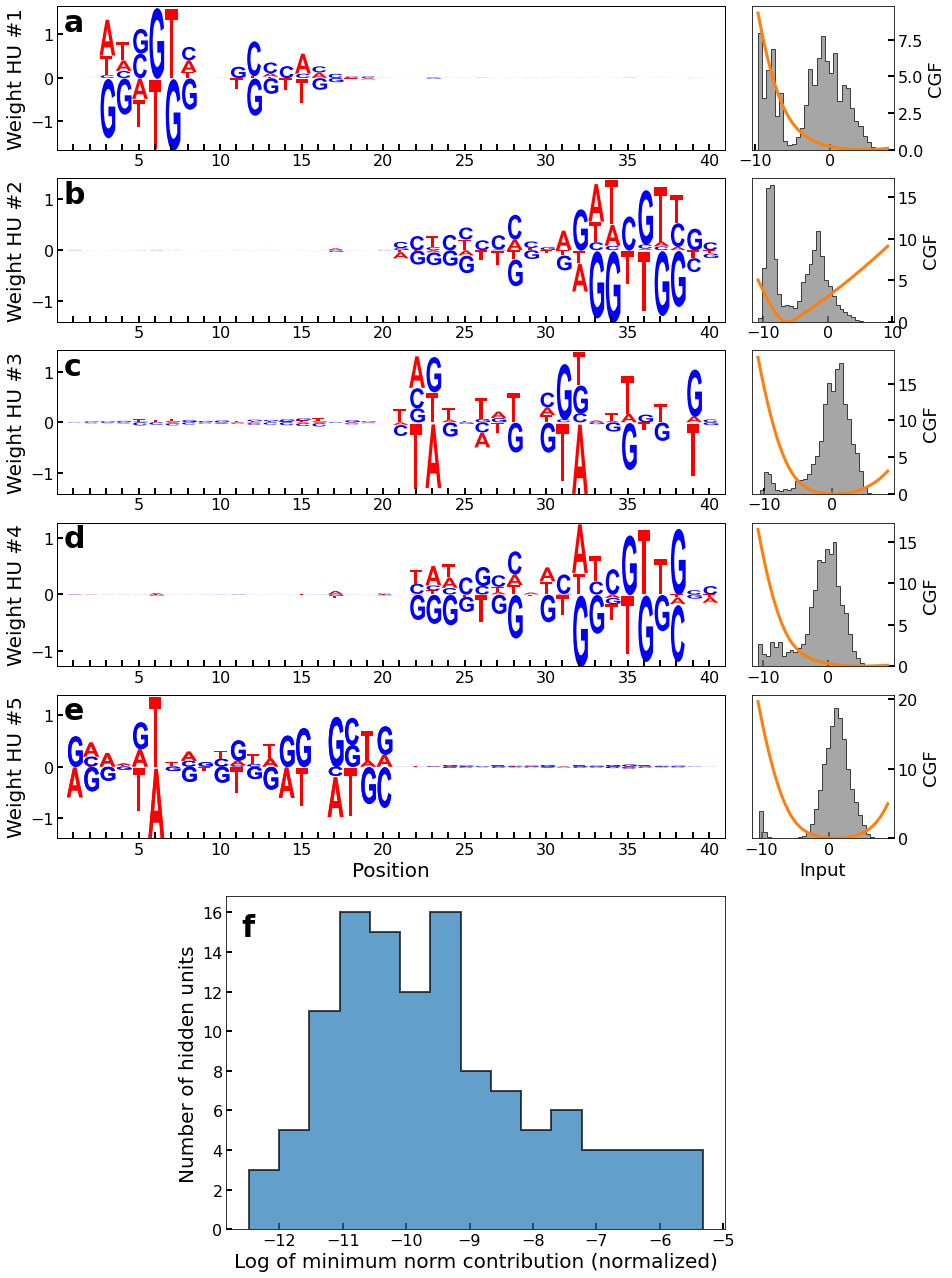

In [8]:
# make figure
add_input_means = False
add_cgfs = True
n_weights = 5
lims = [(-4,1), (-2, 2), (-6, 3), (-5,1), (-5,2)]

if add_cgfs:
    lims = [(np.sum(np.min(w,axis=1)),np.sum(np.max(w,axis=1)))  for w in RBM.weights]
    npoints = 1000
    fullranges = np.array([np.arange(x[0], x[1], (x[1]-x[0]+1/npoints)/npoints) for x in lims], dtype=np.float32)
    pre_cgfs = RBM.hlayer.cgf_from_inputs(fullranges.transpose())
    
fig = plt.figure(figsize=(15, n_weights * 4.5), constrained_layout=False)
wr = [0.2, 0.7, 0.2]
hr = [5/6, 2/6]
gs = fig.add_gridspec(ncols=3, nrows=2, wspace=0.1, hspace=0.1, width_ratios=wr, height_ratios=hr)
##########################################################################################################################
t_gs = gs[0, :].subgridspec(ncols=3, nrows=n_weights, wspace=0.1, hspace=0.2, width_ratios=wr)
for i in range(n_weights):
    t_ax = fig.add_subplot(t_gs[i,0:2])
    DNA_sequence_logo.Sequence_logo(sorted_weights[i], ticks_every=5, ylabel="Weight HU #"+str(i+1), 
                                    ticks_labels_size=16, title_size=20, ax=t_ax);
    if i == n_weights-1:
        DNA_sequence_logo.Sequence_logo(sorted_weights[i], ticks_every=5, ylabel="Weight HU #"+str(i+1), 
                                    ticks_labels_size=16, title_size=20, ax=t_ax);
        t_ax.set_xlabel("Position", fontsize=20)
    t_rect = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=1, edgecolor='black',
                               facecolor='none', transform=t_ax.transAxes, clip_on=False)    
    t_ax.add_patch(t_rect)
    t_ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
    t_ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
    t_ax.text(0.01, 0.83, string.ascii_lowercase[i], fontsize=30, color='k', 
              weight='bold', transform=t_ax.transAxes)
##########################################################################################################################
    t_ax2 = fig.add_subplot(t_gs[i,2])
    ix = order[i]
    if not add_cgfs and not add_input_means:
        t_ax2.hist(I_lr_c[:, ix], bins=30, color='grey', label='All sequences', weights=counts_8, density=True,
               histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
    if add_input_means:
        t_ax22 = t_ax2.twinx()
        I_min = I_lr_c.min()
        I_max = I_lr_c.max()
        I_range = np.asarray((I_max-I_min) * np.arange(0,1+0.01,0.01) + I_min, dtype=np.float32)
        mean = RBM.hlayer.mean_from_inputs(np.repeat(I_range[:,np.newaxis], RBM.n_h, axis=1))
        t_x = I_range
        t_y = mean[:, ix]
        t_ax22.plot(t_x, t_y)
        counts, bins = np.histogram(I_lr_c[:, ix], bins=30, weights=counts_8)
        factor = np.max(t_y) / np.max(counts)
        n,b,p = t_ax2.hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                   histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
        t_ax2.set_yticks([])
        t_ax22.set_ylabel('<HU>', fontsize=18)
        t_ax22.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
        t_ax22.tick_params(axis='both', labelsize=16) 
    if add_cgfs:
        t_x = fullranges[ix]
        t_y = pre_cgfs[:, ix]
        counts, bins = np.histogram(I_lr_c[:, ix], bins=30, weights=counts_8)
        factor = np.max(t_y) / np.max(counts)
        n,b,p = t_ax2.hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
                   histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
        deltay = np.min(t_y)
        t_ax2.plot(t_x, t_y - deltay, lw=3, color='C1')
        t_ax2.set_ylabel('CGF', fontsize=18)
    if i == n_weights-1:
        t_ax2.set_xlabel('Input', fontsize=18)
    t_ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
    t_ax2.tick_params(axis='both', labelsize=16)
    t_ax2.yaxis.tick_right()
    t_ax2.yaxis.set_label_position("right")
##########################################################################################################################
ax3 = fig.add_subplot(gs[1,1])
ax3.hist(np.log(norm_w_mins), bins=15, histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_xlabel('Log of minimum norm contribution (normalized)', fontsize=20)
ax3.set_ylabel('Number of hidden units', fontsize=20)
ax3.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
ax3.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
ax3.tick_params(axis='both', labelsize=16)
ax3.set_yticks(np.array([0,2,4,6,8,10,12,14,16]))
ax3.text(0.03, 0.88, string.ascii_lowercase[n_weights], fontsize=30, 
         color='k', weight='bold', transform=ax3.transAxes)

In [9]:
# Here is a separate cell which does the plot for a user-specified weight

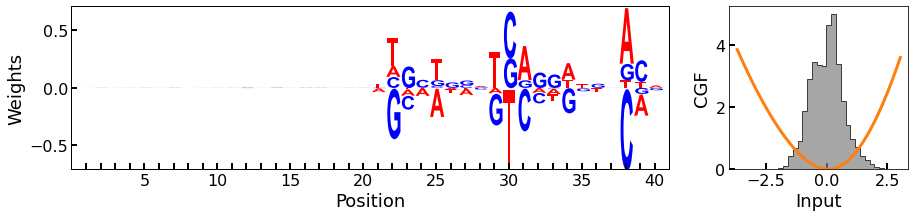

In [10]:
ix = order[113] # weight ranked 113 when sorted for frobenius norm

add_input_means = False
add_cgfs = True
lims = [(np.sum(np.min(w,axis=1)),np.sum(np.max(w,axis=1))) for w in RBM.weights]
npoints = 1000
fullranges = np.array([np.arange(x[0], x[1], (x[1]-x[0]+1/npoints)/npoints) for x in lims], dtype=np.float32)
pre_cgfs = RBM.hlayer.cgf_from_inputs(fullranges.transpose())
fig = plt.figure(figsize=(15, 3), constrained_layout=False)
wr = [0.2, 0.4, 0.2]
gs = fig.add_gridspec(ncols=3, nrows=1, wspace=0.25, hspace=0.1, width_ratios=wr)
t_ax = fig.add_subplot(gs[0,0:2])
DNA_sequence_logo.Sequence_logo(RBM.weights[ix], ticks_every=5, ylabel="Weights", 
                            ticks_labels_size=16, title_size=18, ax=t_ax);
t_ax.set_xlabel("Position", fontsize=18)
t_rect = patches.Rectangle((0.0, 0.0), 1, 1, linewidth=1, edgecolor='black',
                           facecolor='none', transform=t_ax.transAxes, clip_on=False)    
t_ax.add_patch(t_rect)
t_ax.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
t_ax.tick_params(which='minor', direction='in', length=0, width=2, colors='k')
t_ax2 = fig.add_subplot(gs[0,2])
t_x = fullranges[ix]
t_y = pre_cgfs[:, ix]
deltay = np.min(t_y)
counts, bins = np.histogram(I_lr_c[:, ix], bins=30, weights=counts_8)
factor = np.max(t_y) / np.max(counts)
n,b,p = t_ax2.hist(bins[:-1], bins, color='grey', label='All sequences', weights=counts*factor,
           histtype='step', lw=3, fill=True, alpha=0.7, edgecolor='black', linewidth=1)
if add_cgfs:
    t_ax2.plot(t_x, t_y - deltay, lw=3, color='C1')
    t_ax2.set_ylabel('CGF', fontsize=18)
if add_input_means:
    t_ax22 = t_ax2.twinx()
    I_min = I_lr_c.min()
    I_max = I_lr_c.max()
    I_range = np.asarray((I_max-I_min) * np.arange(0,1+0.01,0.01) + I_min, dtype=np.float32)
    mean = RBM.hlayer.mean_from_inputs(np.repeat(I_range[:,np.newaxis], RBM.n_h, axis=1))
    t_x = I_range
    t_y = mean[:, ix]
    t_ax22.plot(t_x, t_y, color='k')
    t_ax22.set_ylabel('<HU>', fontsize=18)
    t_ax22.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
    t_ax22.tick_params(axis='both', labelsize=16)
t_ax2.set_xlabel('Input', fontsize=18)
t_ax2.tick_params(axis='both', direction='in', length=6, width=2, colors='k')
t_ax2.tick_params(axis='both', labelsize=16)
if not add_cgfs:
    t_ax2.set_yticks([])